In [49]:
from stellargraph.data import EdgeSplitter
import stellargraph as sg
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import networkx as nx
import plotly.graph_objs as go
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pickle

edge_path = 'facebook/0.edges' # 0.edges

In [50]:
def operator_hadamard(u, v):
    return u * v

def operator_l1(u, v):
    return np.abs(u - v)

def operator_l2(u, v):
    return (u - v) ** 2

def operator_avg(u, v):
    return (u + v) / 2.0

In [51]:
# Reading the object from the file
with open('best_result.pkl', 'rb') as file:
    best_result = pickle.load(file)

# Reading the objebest_resultct from the file
with open('used_params.pkl', 'rb') as file:
    used_params = pickle.load(file)

workers = multiprocessing.cpu_count()

In [52]:
# Beolvasom a fájlt
with open(edge_path, 'rt') as file:
    text = file.read()

# Feldolgozom a sorokat
connections = []
from_list = []
to_list = []
for row in text.split('\n')[:-1]:
    a, b = [int(x) for x in row.split(' ')]
    connections.append((a, b))

    from_list.append(a)
    to_list.append(b)

In [53]:
# Mivel nem folytonos, ezért átmappelem, hogy folytonos legyen, később az Embedding szeretni fogja
id_mapper = {}
reverse_id_mapper = {}
counter = 0
for elem in from_list:
    if elem not in id_mapper.values():
        id_mapper[counter] = elem
        reverse_id_mapper[elem] = counter
        counter += 1

for elem in to_list:
    if elem not in id_mapper.values():
        id_mapper[counter] = elem
        reverse_id_mapper[elem] = counter
        counter += 1

In [54]:
scaled_connections = []
for first, second in connections:
    first_scaled = reverse_id_mapper[first]
    second_scaled = reverse_id_mapper[second]

    scaled_connections.append((first_scaled, second_scaled))

In [55]:
G = nx.Graph()
G.add_edges_from(scaled_connections)

In [56]:
# ['0', '107']
# G = nx.read_edgelist(edge_path, nodetype=int, create_using=nx.Graph())
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

# is_directed_graph(G)
# Castolás StellarGraph-ra, ment ebben találtam hasznos függvényeket
G = sg.StellarGraph.from_networkx(G)

In [57]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=workers,
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [58]:
model = best_result['classifier']
operator = best_result['binary_operator']

In [59]:
get_embedding_fn = node2vec_embedding(G, "Graph")

Number of random walks for 'Graph': 19980


In [60]:
n = len(G.nodes())

A = np.zeros((n, n))

In [61]:
A.shape

(333, 333)

In [62]:
# Simulate get_embedding and operator functions with dummy values
def get_embedding(node):
    return node  # Replace this with your actual get_embedding logic

def operator(embedding1, embedding2):
    return embedding1 + embedding2  # Replace this with your actual operator logic

# Fill the array using the get_embedding and operator functions
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            first_embedding = get_embedding_fn(node1)
            second_embedding = get_embedding_fn(node2)

            distance_vector = operator(first_embedding, second_embedding)

            prob = model.predict_proba([distance_vector])

            A[node1, node2] = prob[0][0]

# print(A)

In [63]:
predictions = pd.DataFrame(A)

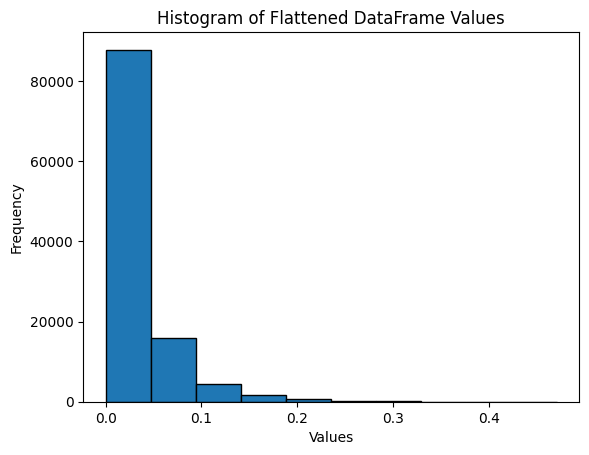

In [64]:
# Flatten the DataFrame using the stack method
flattened_df = predictions.stack().reset_index(drop=True)

# Create a histogram plot
plt.hist(flattened_df, bins=10, edgecolor='k')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened DataFrame Values')
plt.show()

In [65]:
predictions = pd.DataFrame(A)

predictions.columns = G.nodes()
predictions.index = G.nodes()

In [66]:
len(G.nodes())

333

In [67]:
def apply_logic(x):
    return 1 if x > 0.5 else 0

# Apply the function to each value in the DataFrame
predictions_zero_one = predictions.applymap(apply_logic)

In [68]:
predictions_zero_one.sum()

0      0
56     0
1      0
22     0
2      0
      ..
314    0
325    0
315    0
331    0
322    0
Length: 333, dtype: int64

In [69]:
B = np.zeros((n, n))

In [70]:
for v1, v2 in G.edges():
    B[v1, v2] = 1

In [71]:
B

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
A[0,0]

0.0

In [73]:
Űlist(G.nodes())

NameError: name 'Űlist' is not defined

In [ ]:
prob[0][0]

In [ ]:
# get_embedding(322)

In [ ]:
model.predict_proba([distance_vector])